In [4]:
# Load package
import numpy as np; from scipy import stats; import matplotlib.pyplot as plt; import pymc as pm;import arviz as az; 
import math; import pandas as pd
from scipy.optimize import minimize
from scipy import special
import pytensor.tensor as pt
import matplotlib.pyplot as plt

In [5]:
def generate_Corr_identity(p):
    Sigma = np.zeros((p-1, p-1))
    np.fill_diagonal(Sigma, 1)
    return Sigma

def generate_data(n, p, sigma_sqr, beta, nu, corr):

    beta = beta.reshape((p, 1))
    x_i = np.random.normal(0, 1, (n, p - 1))
    x_i_correlated = x_i @ corr
    ones = np.ones((n, 1))
    x_i_full =  np.concatenate((ones, x_i_correlated), axis=1)
    XB = x_i_full @ beta
    E = stats.t.rvs(df = nu, loc=0, scale= np.sqrt(sigma_sqr), size=(n, 1))
    Y = XB + E
    return Y, x_i_full

def negative_log_likelihood_optimize_beta_sigma(params, nu):
    """
    Negative log likelihood that will be passed into minimize function for given nu
    The use of it is to get the numerical result of beta and sigma
    :param params: contains beta and sigma as one vector, dim = p + 1
    :param nu: Degree of freedom
    :param X: Data matrix
    :param y: Observed Value
    :return: The negative log likelihood equation (2) in Fonseca 2008
    """

    betas, sigma = params[:-1], params[-1]
    if sigma <= 0:
        return np.inf  # Return infinity if sigma is non-positive
    p = X.shape[1]
    B = np.reshape(betas, (p, 1))
    XB = X @ B
    n = X.shape[0]
    XB = XB.reshape((n, 1))
    # loglikelihood
    equation = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))
    return -equation

def optimize_over_nu(nu):
    p = X.shape[1]
    bounds = [(None, None)] * p +[(0, np.inf)]
    initial_guess = np.random.normal(0, 1, size = (p+1))
    initial_guess[p] = np.abs(initial_guess[p])
    result = minimize(negative_log_likelihood_optimize_beta_sigma, initial_guess, args=(nu,), method='Nelder-Mead',bounds= bounds)
    if result.success == False:
        print('optimizer error')
        #return [0] * (p + 1)
    #else:
    return result.x# Return the optimized parameters

def profile_loglikelihood(nu):
    sigma = optimize_over_nu(nu)[-1]
    beta = optimize_over_nu(nu)[0:-1]
    
    B = np.reshape(beta, (p, 1))
    XB = X @ B

    #XB = beta1*X[:, 0] + beta2*X[:, 1] + beta3*X[:, 2] + beta4*X[:, 3] + beta5*X[:, 4]
    n = X.shape[0]
    XB = XB.reshape((n, 1))

    eqt = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))
    return -eqt

def Hess_beta_sigma(beta, sigma, nu, X, y):
    """
    The Hessian matrix of the log likelihood function
    :param beta: Coefficients
    :param sigma: Scale
    :param nu: Degree of freedom
    :param X: Data Matrix
    :param y: Observed Value
    :return: Hessian Matrix of beta and sigma on the log likelihood function, equation (2) Fonseca 2008
    """
    p = X.shape[1]
    n = X.shape[0]
    beta = np.array(beta)
    sigma = np.array(sigma)
    total_b2 = 0
    total_b_sigma = 0
    total_sigma_b = 0
    total_s2 = 0
    for i in range(n):
        Xi = np.reshape(X[i,:], (p, 1))
        residual = y[i] - X[i, :] @ beta
        nu_sigma_sqr_plus_residual =  nu*(sigma**2)+ residual**2
        total_b2 = total_b2 + (- (nu_sigma_sqr_plus_residual)* np.outer(X[i,:],X[i, :]) + np.outer(X[i, :], X[i, :])*2*(residual**2))/(nu_sigma_sqr_plus_residual**2)
        #total_b_sigma = total_b_sigma + (- nu_sigma_sqr_plus_residual*2 * residual * X[i,:] + 2*(residual**3 )*X[i,:]) / (nu_sigma_sqr_plus_residual**2)
        total_sigma_b = total_sigma_b + (-2*nu*sigma*X[i,:]*residual)/(nu_sigma_sqr_plus_residual**2)
        total_s2 = total_s2+ (-(residual**2) * 2* nu ) / ( (nu_sigma_sqr_plus_residual**2)) - 2*(residual**2)/(nu_sigma_sqr_plus_residual* (sigma**2))

    db2 = total_b2 * (nu+1)
    #dbs = total_b_sigma * (nu+1)/sigma
    dsb = total_sigma_b * (nu+1)
    dbs = dsb
    ds2 = n/(sigma**2) + (nu+1)*total_s2

    hessian = np.zeros((p + 1, p + 1))
    hessian[:p, :p] = db2
    hessian[:p, p] = dbs
    hessian[p, :p] = dsb
    hessian[p, p] = ds2

    return hessian

def obs_block_det(beta, sigma, nu, X, y):
    
    block = np.array(Hess_beta_sigma(beta, sigma, nu, X, y))* -1
    
    return np.linalg.det(block)

def adj_profile_loglikelihood(nu):
    sigma = optimize_over_nu(nu)[-1]
    beta = optimize_over_nu(nu)[0:-1]
    
    B = np.reshape(beta, (p, 1))
    XB = X @ B

    #XB = beta1*X[:, 0] + beta2*X[:, 1] + beta3*X[:, 2] + beta4*X[:, 3] + beta5*X[:, 4]
    n = X.shape[0]
    XB = XB.reshape((n, 1))
    det = obs_block_det(beta, sigma, nu, X, y)

    adj_eqt = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))-0.5*np.log(abs(det)) 
    return -adj_eqt

# Task 1: Large beta optimizer not working investigation

## true nu = 5, betas = [2, 1, 0.3, 0.9, 1]

In [18]:
# Generate Data
p = 5 #number of betas
beta = np.array([2, 1, 0.3, 0.9, 1])
n = 1000
nu_origin = 5
sigma_sqr = 1.5
corr = generate_Corr_identity(p)  
y, X = generate_data(n, p, sigma_sqr, beta, nu_origin, corr)

optimizer error
optimizer error
optimizer error
optimizer error


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


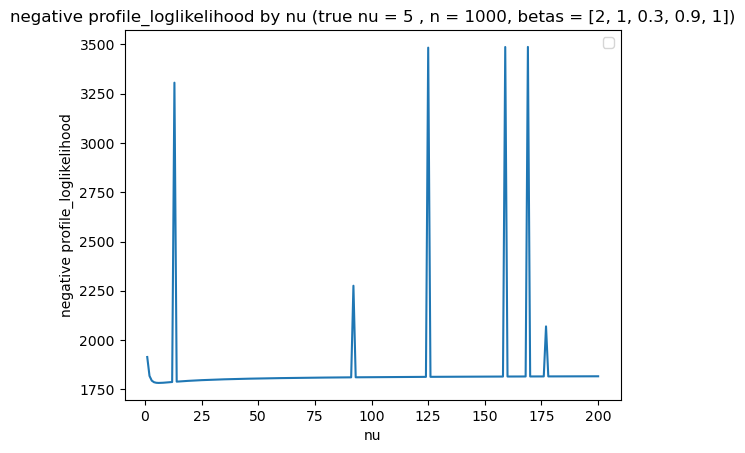

In [19]:
# Profile likelihood Grid search
nu_list =[]
profile_loglikelihood_list = []

for nu in range(1,201):
    nu_list.append(nu)
    profile_loglikelihood_list.append(profile_loglikelihood(nu))
    profile_DF = pd.DataFrame({'nu': nu_list,
                        'profile_loglikelihood': profile_loglikelihood_list,
                        })

# Plotting Profile likelihood
plt.plot(profile_DF['nu'], profile_DF['profile_loglikelihood'])
# Adding labels and legend
plt.xlabel('nu')
plt.ylabel('negative profile_loglikelihood')
plt.title('negative profile_loglikelihood by nu (true nu = 5 , n = 1000, betas = [2, 1, 0.3, 0.9, 1])')
plt.legend()
# Showing the plot
plt.show()

## true nu = 5, betas = [20, 10, 30, 90, 15]

In [20]:
# Generate Data
p = 5 #number of betas
beta = np.array([20, 10, 30, 90, 15])
n = 1000
nu_origin = 5
sigma_sqr = 1.5
corr = generate_Corr_identity(p)  
y, X = generate_data(n, p, sigma_sqr, beta, nu_origin, corr)

optimizer error
optimizer error
optimizer error
optimizer error


/tmp/ipykernel_52/2110946719.py:64: RuntimeWarning: divide by zero encountered in log
  eqt = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))
/tmp/ipykernel_52/2110946719.py:64: RuntimeWarning: divide by zero encountered in divide
  eqt = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))
/tmp/ipykernel_52/2110946719.py:64: RuntimeWarning: invalid value encountered in scalar subtract
  eqt = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))


optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimize

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


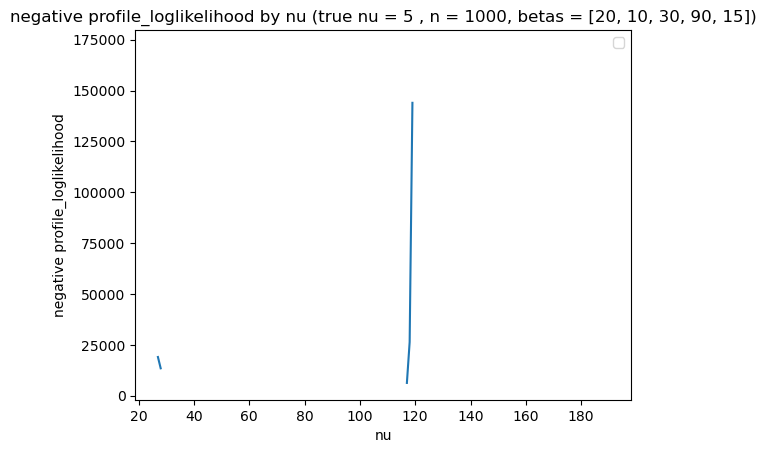

In [21]:
# Profile likelihood Grid search
nu_list =[]
profile_loglikelihood_list = []

for nu in range(1,201):
    nu_list.append(nu)
    profile_loglikelihood_list.append(profile_loglikelihood(nu))
    profile_DF = pd.DataFrame({'nu': nu_list,
                        'profile_loglikelihood': profile_loglikelihood_list,
                        })

# Plotting Profile likelihood
plt.plot(profile_DF['nu'], profile_DF['profile_loglikelihood'])
# Adding labels and legend
plt.xlabel('nu')
plt.ylabel('negative profile_loglikelihood')
plt.title('negative profile_loglikelihood by nu (true nu = 5 , n = 1000, betas = [20, 10, 30, 90, 15])')
plt.legend()
# Showing the plot
plt.show()

# Task 2: High dim fix dataset for each nu

In [3]:
def calculate_y_axix(nu_origin, nu_est):
    n = len(nu_est)
    nu_origin_vec = nu_origin * np.ones((n, 1))
    mse = np.sum((nu_est - nu_origin_vec)**2) / n
    result = np.sqrt(mse)/nu_origin
    return result

# Jeffrey's prior
def logJeff(x):
    return np.log((x/(x+3))**(1/2)*(special.polygamma(1,x/2) - special.polygamma(1, (x+1)/2) - 2*(x+3)/(x*(x+1)**2))**(1/2))

# sigma prior
def logsig(x):
    return -np.log(x)

def logJeff_pymc(x):
    return pt.log((x/(x+3))**(1/2)*(pt.polygamma(1,x/2) - pt.polygamma(1, (x+1)/2) - 2*(x+3)/(x*(x+1)**2))**(1/2))

## N(0,1) beta

In [6]:
# Fix number of observations
n = 30
nu_origin = 5 

result_value_map_profile = []
result_value_map_adj_profile =[] 
result_value_median_Jeff = []

dim_list = []

# Generate data for different dim       
for dim in range(1, 30, 1): ## loop for high dim predictors 
    dim_list.append(dim)
    p = dim
    beta = stats.norm.rvs(size=p)
    sigma_sqr = 1.5
    map_profile =[]
    map_adj_profile =[]
    est_nu_jeff = []
    corr = generate_Corr_identity(p)  
    y, X = generate_data(n, p, sigma_sqr, beta, nu_origin, corr) ## Generate data
        
    for j in range(10): # number of simulations

        # Grid search
        # Profile posterior Grid search MAP --- store all values for each simulation
        profile_post_list = []
        adj_profile_post_list = []
        
        for nu in range(1,11):
            profile_post_list.append(logJeff(nu) - profile_loglikelihood(nu)) # Note: profile_loglikelihood returns negative eqt
            profile_post_df = pd.DataFrame({'profile_post_list': profile_post_list}) 
            adj_profile_post_list.append(logJeff(nu) - adj_profile_loglikelihood(nu)) # Note: adj_profile_loglikelihood returns negative eqt
            adj_profile_post_df = pd.DataFrame({'adj_profile_loglikelihood': adj_profile_post_list})
     
        # profile MAP for one simulation
        profile_result = np.argmax(profile_post_df['profile_post_list']) + 1
        map_profile.append(profile_result)
        # adj profile MAP for one simulation
        adj_profile_result = np.argmax(adj_profile_post_df['adj_profile_loglikelihood']) + 1
        map_adj_profile.append(adj_profile_result)
        
    # Bayesian model 
    with pm.Model() as modelJeff_high_dim: ## Jeff model
        nu = pm.CustomDist('nu', logp=logJeff_pymc, initval = 1)
        sigma = pm.CustomDist('sigma',logp=logsig, initval = 1)
        betas = pm.Flat('betas', shape = (p,1))
        y = pm.StudentT('y', nu = nu, mu = pm.math.dot(X, betas), sigma = sigma, shape = (n,1), observed = y)
        idataJeff_high_dim = pm.sample() 
        with model2:
    map_est_2 = pm.find_MAP()
        est_nu = np.median(idataJeff_high_dim.posterior['nu']) ## Posterior median for a simulation
        est_nu_jeff.append(est_nu) ## Store all posterior medians of same dim in a list

    # record averaged MSE 
    value_map_profile = calculate_y_axix(nu_origin, map_profile)
    result_value_map_profile.append(value_map_profile) 
    
    value_map_adj_profile = calculate_y_axix(nu_origin, map_adj_profile)
    result_value_map_adj_profile.append(value_map_adj_profile) 
    
    value_mse_Jeff = calculate_y_axix(nu_origin, est_nu_jeff)
    result_value_median_Jeff.append(value_mse_Jeff) ## Store MSE for each dim in a list

df = pd.DataFrame({'dim': dim_list,
                    'MSE profile joint': result_value_map_profile,
                   'MSE adj profile joint': result_value_map_adj_profile,
                   'MSE Jeffrey post median': result_value_median_Jeff   
                        })

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 447 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 606 divergences after tuning. Increase `target_accept` or reparameterize.


optimizer error


/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 143 divergences after tuning. Increase `target_accept` or reparameterize.


optimizer error
optimizer error


/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1346 divergences after tuning. Increase `target_accept` or reparameterize.


optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error


/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1135 divergences after tuning. Increase `target_accept` or reparameterize.


optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error


/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 730 divergences after tuning. Increase `target_accept` or reparameterize.


optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimize

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1237 divergences after tuning. Increase `target_accept` or reparameterize.


optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimize

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 406 divergences after tuning. Increase `target_accept` or reparameterize.


optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimize

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 534 divergences after tuning. Increase `target_accept` or reparameterize.


optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimize

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 671 divergences after tuning. Increase `target_accept` or reparameterize.


optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimize

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 510 divergences after tuning. Increase `target_accept` or reparameterize.


optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimize

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 783 divergences after tuning. Increase `target_accept` or reparameterize.


optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimize

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 484 divergences after tuning. Increase `target_accept` or reparameterize.


optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimize

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 541 divergences after tuning. Increase `target_accept` or reparameterize.


optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimize

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1949 divergences after tuning. Increase `target_accept` or reparameterize.


optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimize

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1016 divergences after tuning. Increase `target_accept` or reparameterize.


optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimize

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 544 divergences after tuning. Increase `target_accept` or reparameterize.


optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimize

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 804 divergences after tuning. Increase `target_accept` or reparameterize.


optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimize

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1369 divergences after tuning. Increase `target_accept` or reparameterize.


optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimize

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 381 divergences after tuning. Increase `target_accept` or reparameterize.


optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimize

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1146 divergences after tuning. Increase `target_accept` or reparameterize.


optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimize

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1166 divergences after tuning. Increase `target_accept` or reparameterize.


optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimize

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1264 divergences after tuning. Increase `target_accept` or reparameterize.


optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimize

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 155 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimize

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 282 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 268 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimize

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 240 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimize

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 208 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 131 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimize

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 117 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 639 divergences after tuning. Increase `target_accept` or reparameterize.


optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimizer error
optimize

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 260 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 367 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


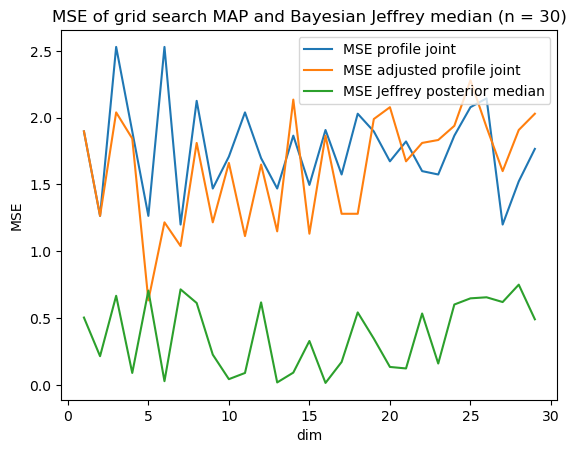

In [7]:
# Plot profile MAP(grid search) vs nu 

# Plotting
plt.plot(df['dim'], df['MSE profile joint'], label='MSE profile joint')
plt.plot(df['dim'], df['MSE adj profile joint'], label='MSE adjusted profile joint')
plt.plot(df['dim'], df['MSE Jeffrey post median'], label='MSE Jeffrey posterior median')
# Adding labels and legend
plt.xlabel('dim')
plt.ylabel('MSE')
plt.title('MSE of grid search MAP and Bayesian Jeffrey median (n = 30)') 
plt.legend()
# Showing the plot
plt.show()